In [8]:
from db import connect_npsql, convert_array, get_sector_list
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq
from process_field_impl import *


con = connect_npsql('../../ed_data/master_133.db')
# con = connect_npsql('../../ed_data/results_old.db')
con.execute("PRAGMA journal_mode=WAL")
con.commit()



In [9]:

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)

In [10]:
lats = load_geometries(con)
print("Loaded geometries: ")
for l in lats:
    print(convert_sparray(l))
    

Loaded geometries: 
[[0 12 12]
 [4 0 12]
 [4 12 0]]
[[0 12 12]
 [-4 0 -12]
 [-4 -12 0]]


In [11]:
xx, sec, sec_E, sec_names = find_groundstate_111(con, lats[1], 1)

IndexError: index 1 is out of bounds for axis 1 with size 1

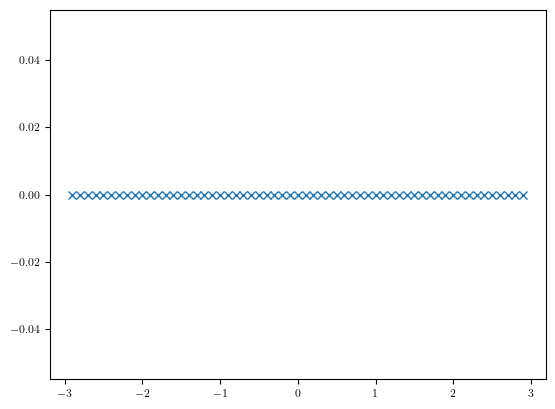

In [6]:
for J in range(3):
    plt.plot(xx, np.array(sec)[:,J],'x',label=f"ex state {J}")

plt.legend()

unique_sectors = {}
for sec_ids in sec:
    gs_sec_id = sec_ids[0]
    unique_sectors[gs_sec_id] = sec_names[gs_sec_id]

print(unique_sectors)

In [ ]:

def add_phasedia_boundaries(a, jpm_arr, B_arr, B_direction, **kwargs):
    B = np.array(B_direction,dtype=np.float64)
    B /= np.linalg.norm(B)

    
    
    f0 = lambda j,b : Jring(j, b*B)[0] + 0.5*sum(Jring(j, b*B)[1:3])
    f1 = lambda j,b : Jring(j, b*B)[1]


    
    sing_vals_0 = []
    sing_vals_1 = []
    for bb in B_arr:
        res0, res1 = None, None
        try:
            res0 = brentq(f0, 0.000000001, np.max(jpm_arr)*2,args=bb)
        except ValueError:
            res0 =  None

        try:
            if res0 is not None:
                res1 = brentq(f1, res0*0.01, res0*0.9,args=bb)
            else:
                res1 = brentq(f1, 0.01, 0.2,args=bb)
        except ValueError:
            res1 =  None

       
        
        sing_vals_0.append(res0)
        sing_vals_1.append(res1)
            
    
    # a.axvline(0,**kwargs)
    a.plot(sing_vals_0, B_arr, **kwargs)
    a.plot(sing_vals_1, B_arr, **kwargs)
    # a.plot( 0.455 * B_arr**2,B_arr, **kwargs)
    # a.plot( 0.09 * B_arr**2,B_arr, **kwargs)
    a.set_xlim([np.min(jpm_arr), np.max(jpm_arr)])

In [ ]:
# Check quality of interpolation



def plot_interp_quality(rfi, x_lims = [-4.2, 4.2], recip=False):
    fig, Ax = plt.subplots(2,2, sharey=True)
    Ax2 = np.array([[ax.twinx() for ax in row] for row in Ax])

    power = -1 if recip else 1
    
    Ax[0,0].set_title(r'$g_{1,2,3}>0$')
    Ax[0,0].plot(np.array(rfi.x_list[1])**power, np.array(rfi.expO_series[1]).T,'.')
    
    
    Ax[0,1].plot(np.array(rfi.x_list[-1])**power, np.array(rfi.expO_series[-1]).T,'.')
    Ax[0,1].set_title(r'$g_{1,2,3}<0$')
    
    Ax[1,0].plot(np.array(rfi.x_list[1])**power, np.array(rfi.expO_series[1]).T,'.')
    Ax[1,1].plot(np.array(rfi.x_list[-1])**power, np.array(rfi.expO_series[-1]).T,'.')
    
    xx = np.linspace(np.min(rfi.x_list[1]), np.max(rfi.x_list[1]), 120)
    
    xx_detail = np.linspace(*x_lims, 120)
    
    for i, xax in enumerate([xx, xx_detail]):
        Ax[i,0].plot(xax, [rfi.interpolate_ring(1, x**power) for x in xax])
        Ax[i,1].plot(xax, [rfi.interpolate_ring(-1, x**power) for x in xax])
    
    for a in Ax[1]:
        a.set_xlim(x_lims)
        a.set_ylim([-0.5,0.5])

    xl = r'$g_{1,2,3}/g_0$' if recip else r'$g_0/g_{1,2,3}$'
    
    Ax[1,0].set_xlabel(xl)
    Ax[1,1].set_xlabel(xl)


def plot_E_interp_quality(rfi, x_lims = [-4.2, 4.2], y_lims = [-12,-4], recip=False):
    fig, Ax = plt.subplots(2,2)
    # Ax2 = np.array([[ax.twinx() for ax in row] for row in Ax])
 
    Ax[0,0].set_title(r'$g_{1,2,3}>0$')
    # Ax[0,0].plot(rfi.x_list[1], rfi.E_list[1]-rfi.E_list[1][0,:],'.')
    # Ax[1,0].plot(rfi.x_list[1], rfi.E_list[1]-rfi.E_list[1][0,:],'.')

    power = -1 if recip else 1
    for a in [Ax[0,0], Ax[1,0]]:
        a.plot(np.pow(rfi.x_list[1],power), rfi.E_list[1][:, 0:2],'.')
    
    Ax[0,1].set_title(r'$g_{1,2,3}<0$')
    for a in [Ax[0,1], Ax[1,1]]:
        a.plot(np.pow(rfi.x_list[-1],power), rfi.E_list[-1][:,0:2],'.')
    
    
    
    xx = np.linspace(np.min(rfi.x_list[1]), np.max(rfi.x_list[1]), 120)
    
    xx_detail = np.linspace(*x_lims, 120)
    
    for i, xax in enumerate([xx, xx_detail]):
        # Ax[i,0].plot(xax, [rfi.es1_interpolators[1](x)-rfi.gse_interpolators[1](x) for x in xax],color='k')
        
        # Ax[i,1].plot(xax, [rfi.es1_interpolators[-1](x)-rfi.gse_interpolators[-1](x) for x in xax],color='k')
        Ax[i,0].plot(xax, [rfi.gse_interpolators[1](x**power) for x in xax],color='k')
        Ax[i,0].plot(xax, [rfi.es1_interpolators[1](x**power) for x in xax],color='r')
        
        Ax[i,1].plot(xax, [rfi.gse_interpolators[-1](x**power) for x in xax],color='k')
        Ax[i,1].plot(xax, [rfi.es1_interpolators[-1](x**power) for x in xax],color='r')
    
    for a in Ax[1]:
        a.set_xlim(x_lims)
        a.set_ylim(y_lims)

    # for a in Ax[0]:
    #     # a.set_xlim(x_lims)
    #     a.set_ylim([0,2])
    if recip:
        Ax[1,0].set_xlabel(r'$g_{1,2,3}/g_0$')
        Ax[1,1].set_xlabel(r'$g_{1,2,3}/g_0$')
    else:
        Ax[1,0].set_xlabel(r'$g_0/g_{1,2,3}$')
        Ax[1,1].set_xlabel(r'$g_0/g_{1,2,3}$')



In [ ]:
sec_names

In [ ]:
from scipy.interpolate import PchipInterpolator
LinearInterpolator = lambda X,Y : lambda x : np.interp(x,X,Y)

# lattice = lats[2]

# sector = (4,4,4,4)

rfi_111 = RingInterpolator_111(lats[0], sector = (4,2,6,6), interpolation_f=PchipInterpolator)

# rfi_111 = RingInterpolator_111(lats[3], sector = (6,6,6,6), interpolation_f=PchipInterpolator)
# rfi_111 = RingInterpolator_111(lats[1], sector = (8,8,8,8), interpolation_f=PchipInterpolator)
# rfi_111 = RingInterpolator_111(lats[3], sector = (9,9,10,8), interpolation_f=PchipInterpolator)
# rfi_111 = RingInterpolator_111(lats[3], sector = (9,9,8,10), interpolation_f=PchipInterpolator)

plot_E_interp_quality(rfi_111, x_lims = [-3,3], recip=False,y_lims = [-22,-8])
plot_E_interp_quality(rfi_111, x_lims = [-3,3], recip=True,y_lims = [-404,44])

In [ ]:
from matplotlib import colors

jpm_arr, B_arr, rf_vals, gap_vals, x_vals = calc_phasedia_data(rfi = rfi_111, field_direction = [1,1,1])

fig, Ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(3.5,3))
c = []
lettr = ord('e')
for sl, ax in enumerate(Ax.ravel()):

    # ax = Ax[ij]
    c.append(
        ax.contourf(jpm_arr, B_arr, rf_vals[sl],
                    extend='both',
                            levels=np.linspace(-0.5,0.5,21),
                          cmap='Spectral')
    )

    ax.text(0.05,0.05,rf"$\Re \langle O_{sl} \rangle$",transform=ax.transAxes)
    ax.text(0.05,0.95,f"{chr(lettr)})",transform=ax.transAxes,verticalalignment='top')
    lettr += 1

Ax[1,0].set_xlabel(r"$J_{\pm}$")
Ax[1,1].set_xlabel(r"$J_{\pm}$")
Ax[0,0].set_ylabel(r"$B_{111}$")
Ax[1,0].set_ylabel(r"$B_{111}$")


for a in Ax.ravel():
    add_phasedia_boundaries(a,jpm_arr, B_arr, [1,1,1], color='k',lw=1)

fig.colorbar(c[0],ax=Ax)
# fig.savefig("/Users/alaricsanders/Desktop/222_B111_ED_ring_phase_dia.pdf")

In [ ]:
# the gap closing diagram

n = matplotlib.colors.LogNorm(vmin=1e-8, vmax=0.01, clip=True)
fig, ax = plt.subplots()
c = ax.pcolormesh(jpm_arr, B_arr, gap_vals,norm=n)
# c = ax.pcolormesh(jpm_arr, B_arr, x_vals,vmax=11,vmin=-11)
fig.colorbar(c)
add_phasedia_boundaries(ax,jpm_arr, B_arr, [1,1,1], color='k',lw=1)

# fig.savefig("~/Desktop/222_ED_ring_phase_dia.png")
# # cax = fig.add_axes([0.9,0.4,0.05,0.4])
# fig, ax = plt.subplots()
# c = ax.pcolormesh(jpm_arr, B_arr, x_vals, vmin=-4, vmax=4, cmap='RdYlBu')
# fig.colorbar(c)

In [ ]:
# rfi_110 = RingInterpolator_110(lats[0],(4,4,4,4),interpolation_f=LinearInterpolator )

# rfi_110 = RingInterpolator_110(lats[1],(6,6,6,6),interpolation_f=LinearInterpolator )

rfi_110 = RingInterpolator_110(lats[3],(9,9,8,10),interpolation_f=LinearInterpolator )

plot_E_interp_quality(rfi_110)

In [ ]:
# FINAL PLOT

import itertools


def make_summary_plot(fig, rfi_111, rfi_110,
    bottom = 0.15,
    height = 0.37,
    left = 0.26,
    left2 = 0.07,
    width = 0.13,
    wspace = 0.02,
    hspace =0.028
                      
                     ):
    
    
    Ax = [[],[]]
    
    for i in range(4):
        Ax[1].append( fig.add_axes([left+i*(width + wspace), bottom, width, height ])    )
        Ax[0].append( fig.add_axes([left+i*(width + wspace), bottom+height+hspace, width, height ]) )
    
    
    Ax2 = [fig.add_axes([left2, bottom+height+hspace, width, height]),fig.add_axes([left2, bottom, width, height])]
    
    c = []
    c_gap = []
    for ax_l, ax2, rfh, field_dir in zip(
        Ax, Ax2, [rfi_111, rfi_110], [[1,1,1], [0,1,1]]):
        jpm_arr, B_arr, rf_vals, gap_vals, x_vals = calc_phasedia_data(rfi = rfh, field_direction = field_dir)
        for sl in range(4):
            ax = ax_l[sl]
            c.append( ax.contourf(jpm_arr, B_arr, rf_vals[sl],levels=np.linspace(-0.4,0.4,41),cmap='Spectral') )
            add_phasedia_boundaries(ax, jpm_arr, B_arr, field_dir, ls=':', zorder=100,
                                    color='k',lw=1)
            
            ax.set_xticks([-0.1,-0.05,0,0.05,0.1])
            ax.set_xticklabels([])
            
            # if sl != 0:
            ax.set_yticklabels([])
    
        n = matplotlib.colors.LogNorm(vmin=1e-9, vmax=1e-4, clip=True)
        c_gap.append(ax2.pcolormesh(jpm_arr, B_arr, gap_vals,norm=n))
        ax2.set_xticks([-0.1,-0.05,0,0.05,0.1])
        ax2.set_xticklabels([])
        add_phasedia_boundaries(ax2, jpm_arr, B_arr, field_dir, ls=':', color='k',lw=1)
    
    Ax2[-1].set_xticklabels([-0.1,'',0,'',0.1])
    
    for sl, a in enumerate(Ax[0]):
        # a.text(0.05,0.05,rf"$\Re \langle O_{sl} \rangle$",transform=ax.transAxes)
        a.set_title(rf"$\Re \langle O_{sl} \rangle $")
    
    
    for a in itertools.chain(Ax[-1],[Ax2[1]]):
        a.axvline(0,color='k',lw=1,ls=':')
    
    # subplot labels 
    lettr= ord('a')
    for row in range(2):
        for a in itertools.chain([Ax2[row]],Ax[row]):
            a.text(0.05,0.05,f"{chr(lettr)})",transform=a.transAxes,verticalalignment='bottom')
            lettr += 1
    
    
    # gap closing guides


    for a in itertools.chain(Ax[1], [Ax2[1]]):
        a.set_xlabel(r'$J_\pm/J_y$')
        a.set_xticklabels([-0.1,'',0,'',0.1])
        a.tick_params(axis='x', labelrotation=0)
        a.set_xlim([-0.1,0.1])
    
    
    # Ax[0][0].set_ylabel(r'$B_{111}$')
    Ax2[0].set_ylabel(r'$B_{111}$')
    # Ax[1][0].set_ylabel(r'$B_{011}$')
    Ax2[1].set_ylabel(r'$B_{011}$')
    
    
    
    cax_x = left2+width+wspace*0.5
    cax = fig.add_axes(
        [left+width*4+wspace*3.5,bottom, 0.01, height*2 + hspace]
        # [cax_x,bottom, 0.01, height]
    )
    fig.colorbar(c[0],ax=Ax,cax=cax)

    # the gap colorbar
    cax2 = fig.add_axes(
        [left2+(width+wspace/2),bottom, 0.01, height*2 + hspace]
        # [cax_x,bottom+height+hspace, 0.01, height]
        # [left2, height
    )
    Ax2[0].set_title(r'Gap / $J_y$')
    fig.colorbar(c_gap[0],ax=Ax2,cax=cax2)

In [ ]:
fig = plt.figure(figsize=(7,3))
lat = lats[3]
sector = (9,9,8,10)

# lat = lats[2]
# sector = (6,6,6,6)

# lat = lats[1]
# sector = (8,8,8,8)

make_summary_plot(fig, 
                  rfi_110=RingInterpolator_110(lats[4],sector=(9,9,8,10),interpolation_f=PchipInterpolator ),
                  rfi_111=RingInterpolator_111(lats[3],sector=(6,6,6,6),interpolation_f=PchipInterpolator ),
    bottom = 0.15,
    height = 0.37,
    left = 0.3,
    left2 = 0.07,
    width = 0.14,
    wspace = 0.02,
    hspace =0.032
                 )
fig.savefig('/Users/alaricsanders/Desktop/unified_flux_phases_ED.pdf')
fig.add_axes([0,0,1,1]).patch.set_alpha(0)

In [ ]:
# rfi_110 = RingInterpolator_110(lats[0],(4,4,4,4),interpolation_f=LinearInterpolator )
# rfi_110 = RingInterpolator_110(lats[1],(6,6,6,6),interpolation_f=LinearInterpolator )
rfi_110 = RingInterpolator_110(lats[2],(9,9,8,10),interpolation_f=LinearInterpolator )

plot_interp_quality(rfi_110)
plot_E_interp_quality(rfi_110)

In [ ]:
jpm_arr, B_arr, rf_vals, gap_vals, _ = calc_phasedia_data(rfi = rfi_110, field_direction = [0,1,1])

fig, Ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(3.5,3))
c = []

lettr = ord('a')
for sl, ax in enumerate(Ax.ravel()):
    
    # ax = Ax[ij]
    c.append(
        ax.contourf(jpm_arr, B_arr, rf_vals[sl],
                       extend='both',
                            levels=np.linspace(-0.5,0.5,21),
                          cmap='Spectral')
    )

    ax.text(0.05,0.05,rf"$\Re \langle O_{sl} \rangle$",transform=ax.transAxes)
    ax.text(0.05,0.95,f"{chr(lettr)})",transform=ax.transAxes,verticalalignment='top')
    
    lettr += 1

Ax[1,0].set_xlabel(r"$J_{\pm}$")
Ax[1,1].set_xlabel(r"$J_{\pm}$")
Ax[0,0].set_ylabel(r"$B_{110}$")
Ax[1,0].set_ylabel(r"$B_{110}$")


for a in Ax.ravel():
    add_phasedia_boundaries(a,jpm_arr, B_arr, [0,1,1],color='k')

fig.colorbar(c[0],ax=Ax)

fig.savefig("/Users/alaricsanders/Desktop/222_B110_ED_ring_phase_dia.pdf")


n = matplotlib.colors.LogNorm(vmin=1e-9, vmax=1e-4, clip=True)
# n = matplotlib.colors.Normalize(vmin=0, vmax=1e-4, clip=True)
fig, ax = plt.subplots()
ax.plot(-0.45*B_arr**2+0.36*B_arr**4, B_arr, ':', color='r')
c = ax.pcolormesh(jpm_arr, B_arr, gap_vals,norm=n)
fig.colorbar(c)
add_phasedia_boundaries(ax,jpm_arr, B_arr, [0,1,1],color='k')

# Gap closing scaling

In [ ]:
def n_cells(lat_vecs):
    V0 = np.linalg.det([[0,4,4],[4,0,4],[4,4,0]])
    return int(abs(np.round(np.linalg.det(np.array(convert_sparray(lat_vecs),dtype='int'))/V0)))

In [ ]:
lat_sector_sets = [
    (lats[0], (4,4,4,4)),
    (lats[1], (6,6,6,6)),
    # (lats[1], (12,4,4,4)),
    (lats[2], (9,9,8,10))
]

rfi_110_sets = [RingInterpolator_110(lat, sector, interpolation_f=LinearInterpolator) for lat, sector in lat_sector_sets]
rfi_111_sets = [RingInterpolator_111(lat, sector, interpolation_f=LinearInterpolator) for lat, sector in lat_sector_sets]


In [ ]:

fig, Ax = plt.subplots(2)
power = 1
for ax, rfi_sets in zip(Ax, [rfi_110_sets, rfi_111_sets]):
    for (lat,_), rfi, c in zip(lat_sector_sets, rfi_sets,['r','g','b','orange']):
        # ax.plot(np.pow(rfi.x_list[1],power), (rfi.E_list[1][:, 1]-rfi.E_list[1][:, 0])/n_cells(lat),'.')
        el = np.sort(np.real(rfi.E_list[1]),axis=1)
        ax.plot(rfi.x_list[1], (el[:, 1]-el[:, 0])/n_cells(lat),'+',color=c)
        # ax.plot(rfi.x_list[1], (el[:, 2]-el[:, 0])/n_cells(lat),'+',color=c)
    
    ax.axhline(0,color='k',lw=0.4)
    ax.set_ylabel(r"Gap / eV\,$\rm{cell}^{-1}$")
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1])
    
ax110, ax111 = Ax

# ax110.set_ylim([-0.1,0.2])

# ax111.set_ylim([-0.1,0.2])

ax110.set_xlim([-1,1])
ax111.set_xlim([-3,1])

ax110.legend([f"{n_cells(lat)*4} sites" for lat, _ in lat_sector_sets])